In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

from pandas import DataFrame 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.ticker as ticker
from sklearn import preprocessing

In [2]:
import sys, os
print(os.listdir())

['.git', '008_P_amp_maps_2265P01.csv', 'Bad_Channels.ipynb', 'Bad_Channels_Logistic_Regression.ipynb', 'decode_listing_features_003.csv', 'decode_listing_features_010.csv', 'README.md']


In [3]:
stats1=pd.read_csv('decode_listing_features_003.csv')
stats1['SEQ']=3
#stats1a=pd.read_csv('decode_listing_features_010.csv')
#stats1a['SEQ']=10
#stats1b=pd.read_csv('decode_listing_features004.csv')
#stats1b['SEQ']=4
#stats1c=pd.read_csv('decode_listing_features010.csv')
#stats1c['SEQ']=10
#stats1d=pd.read_csv('decode_listing_features011.csv')
#stats1d['SEQ']=11
#stats1=stats1.append(stats1a)
#stats1=stats1.append(stats1b)
#stats1=stats1.append(stats1c)
#stats1=stats1.append(stats1d)

In [4]:
stats1.head()

,BAD_CHAN_FLAG,CAP_CUT_ERR,CAP_ERR,CAP_VAL,CHANNEL,DEEP_RMS,DEVICE,LEAK_ERR,LEAK_VAL,MARG_CHAN_FLAG,SENS,SEQ
0,0.0,0.0,0.0,249.508224,1,14.61,1.0,0.0,5.0,0.0,38.31,3
1,0.0,0.0,0.0,248.342239,2,14.11,0.0,0.0,5.0,0.0,38.28,3
2,0.0,0.0,0.0,249.030304,3,14.22,1.0,0.0,5.0,0.0,38.04,3
3,0.0,0.0,0.0,246.959259,4,13.30,0.0,0.0,5.0,0.0,38.15,3
4,0.0,0.0,0.0,250.354599,5,13.20,0.0,0.0,5.0,0.0,38.22,3


In [5]:
stats2=pd.read_csv('008_P_amp_maps_2265P01.csv')
stats2['SEQ']=8
#stats2a=pd.read_csv('003_P_amp_maps.csv')
#stats2a['SEQ']=3
#stats2b=pd.read_csv('004_P_amp_maps.csv')
#stats2b['SEQ']=4
#stats2c=pd.read_csv('010_P_amp_maps.csv')
#stats2c['SEQ']=10
#stats2d=pd.read_csv('011_P_amp_maps.csv')
#stats2d['SEQ']=11
#stats2=stats2.append(stats2a)
#stats2=stats2.append(stats2b)
#stats2=stats2.append(stats2c)
#stats2=stats2.append(stats2d)

In [6]:
stats2.head()

,SRC_POINT,CHANNEL,WC_RMS,TGT_RMS,DEEP_RMS,WHOLE_RMS,FFID,CABLE,CABTR,SEQ
0,1001,1,20.214577,210.530777,12.440019,1045.397705,1001,1,1,8
1,1001,2,15.753899,207.250076,18.285044,1058.347046,1001,1,2,8
2,1001,3,10.252005,201.711441,14.983429,1037.041016,1001,1,3,8
3,1001,4,11.665508,202.110245,13.177336,1043.912354,1001,1,4,8
4,1001,5,12.001275,205.250626,15.401988,1018.429810,1001,1,5,8


In [7]:
std_=stats2.groupby(['SEQ','CHANNEL'])['DEEP_RMS'].agg(np.std)

In [8]:
std_=pd.DataFrame(std_)

In [9]:
std_.sort_values(['SEQ','CHANNEL'],inplace=True)
stats1.sort_values(['SEQ','CHANNEL'],inplace=True)

In [10]:
std_.reset_index(inplace=True)
len(std_)

7680

In [11]:
len(stats1)

7680

In [12]:
std_.head()

,SEQ,CHANNEL,DEEP_RMS
0,8,1,8.103719
1,8,2,8.602786
2,8,3,11.263492
3,8,4,8.336817
4,8,5,8.139459


In [13]:
df1=pd.merge(std_,stats1 , how='left', left_on=['SEQ','CHANNEL'], right_on=['SEQ','CHANNEL'])
df2=df1.copy()

In [14]:
df2.head(10)

,SEQ,CHANNEL,DEEP_RMS_x,BAD_CHAN_FLAG,CAP_CUT_ERR,CAP_ERR,CAP_VAL,DEEP_RMS_y,DEVICE,LEAK_ERR,LEAK_VAL,MARG_CHAN_FLAG,SENS
0,8,1,8.103719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,2,8.602786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,3,11.263492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8,4,8.336817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,5,8.139459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,8,6,7.434583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,8,7,6.932682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,8,6.931952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,9,6.944732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,8,10,6.834498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
a=stats2['TGT_RMS']

In [16]:
b=a.to_list()

In [17]:
c= np.reshape(b,(-1,7680))
c=np.transpose(c)

In [18]:
c=np.clip(c,0,100)

In [19]:
%matplotlib inline

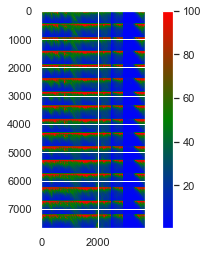

In [20]:
import matplotlib.colors as colly

cmap1= colly.LinearSegmentedColormap.from_list("" , ['blue','green','red'])

im=plt.imshow(c, cmap=cmap1)
plt.colorbar(im)
plt.rcParams["figure.figsize"] = (70,20)
plt.savefig('RMS.png')

plt.show()